# Рекомендательные системы

#### Mindset, 2021.

## 1. Постановка задачи

Каждый день мы пользуемся многочисленными сервисами, например, YouTube, Amazon, Netflix, TikTok. Важнейшей частью их функционирования является отлаженная рекомендательная система, которая предлагает пользователям продукты, которые ему наиболее вероятно понравятся на основании продуктов, которые ему понравились ранее.

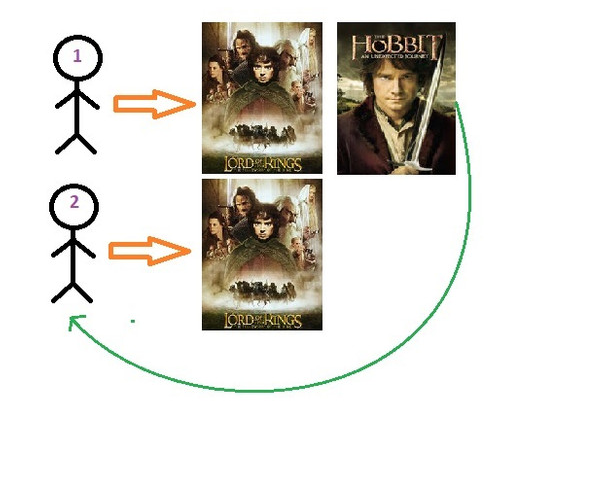

## 2. Загрузка и визуализация датасетов

Мною использованы материалы отсюда: [[1]](https://www.kaggle.com/rounakbanik/movie-recommender-systems), [[2]](https://www.youtube.com/watch?v=kfhqzkcfMqI), [[3]](https://www.kaggle.com/fuzzywizard/rec-sys-collaborative-filtering-dl-techniques).

In [1]:
# Ignore warnings :
import warnings
warnings.filterwarnings('ignore')


# Handle table-like data and matrices :
import numpy as np
import pandas as pd
import math 
import itertools

# Modelling Helpers :
from sklearn.preprocessing import Normalizer , scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV , KFold , cross_val_score



# Evaluation metrics :

# Regression
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error 

# Classification
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score


# Deep Learning Libraries
#import keras
#from keras.models import Sequential, load_model
#from keras.layers import Dense, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
#from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
#from keras.preprocessing.image import ImageDataGenerator
#from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
#from keras.utils import to_categorical


# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import missingno as msno


# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
plt.style.use('fivethirtyeight')
sns.set(context="notebook", palette="dark", style = 'whitegrid' , color_codes=True)

In [42]:
# Center all plots
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""");


# Make Visualizations better
params = { 
    'axes.labelsize': "medium",
    'xtick.labelsize': 'medium',
    'legend.fontsize': 25,
    'figure.dpi': 100,
    'figure.figsize': [5, 3]
}
plt.rcParams.update(params)

Загружаем данные

In [2]:
ratings = pd.read_csv('ratings.csv')
movies = pd.read_csv('movies.csv')
df_r = ratings.copy()
df_m = movies.copy()

#### Датасет с рейтингами выглядит следующим образом:

In [3]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


* **userId** - Каждый пользователь имеет персоналный Id.
* **movieId** - Каждый фильм имеет персональный Id.
* **rating** - Рейтинг, который поставил соответствующий пользователь соответстующему фильму.
* **timestamp** - Временная отметка оценки.

In [4]:
ratings.shape

(100836, 4)

In [5]:
ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


Из описания можно сделать выводы:

1. Минимальная оценка, поставленная какому-либо фильму, равна 0.5, максимальная - 5.0
2. Средняя оценка среди всех пользователей и всех фильмов - 3.5
3. Пользователи имеют Id в диапазоне от 1 до 610
4. Фильмы имеют Id от 1 до 193609 

Временные отметки нас не интересуют, поэтому избавимся от них.

In [6]:
ratings.drop(['timestamp'], axis=1, inplace=True)

In [7]:
ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


#### Датасет с фильмами выглядит следующим образом:

In [8]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


* **movieId** - Персональный Id фильма.
* **title** - Название фильма, соответсвующего данному Id.
* **genres** - Отражает жанр фильма.

In [9]:
print('Shape: ', movies.shape, '\n')
movies.info()

Shape:  (9742, 3) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


Соединим датасеты в один

In [10]:
df_combined = pd.merge(ratings, movies, on = 'movieId')

In [11]:
df_combined.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [12]:
df_combined.shape

(100836, 5)

#### Взглянем на то, какие жанры представлены в нашем датасете:

In [13]:
# Create a function to find genres in the dataset

genres = {} # create a dictionary to store different genre values

def find_genres():
    for genre in movies['genres']:
        words = genre.split('|')
        for word in words:
            genres[word] = genres.get(word, 0) + 1
            
find_genres()

In [14]:
genres

{'Adventure': 1263,
 'Animation': 611,
 'Children': 664,
 'Comedy': 3756,
 'Fantasy': 779,
 'Romance': 1596,
 'Drama': 4361,
 'Action': 1828,
 'Crime': 1199,
 'Thriller': 1894,
 'Horror': 978,
 'Mystery': 573,
 'Sci-Fi': 980,
 'War': 382,
 'Musical': 334,
 'Documentary': 440,
 'IMAX': 158,
 'Western': 167,
 'Film-Noir': 87,
 '(no genres listed)': 34}

In [15]:
# replace '(no genres listed)' by 'None'
genres['None'] = genres.pop('(no genres listed)')

#### Проанализируем количество оценок на фильм

In [16]:
df_n_ratings = pd.DataFrame(df_combined.groupby('title')['rating'].mean())
df_n_ratings['total ratings'] = pd.DataFrame(df_combined.groupby('title')['rating'].count())
df_n_ratings.rename(columns = {'rating': 'mean ratings'}, inplace=True)

df_n_ratings.sort_values('total ratings', ascending=False).head(10)

,mean ratings,total ratings
title,,
Forrest Gump (1994),4.164134,329
"Shawshank Redemption, The (1994)",4.429022,317
Pulp Fiction (1994),4.197068,307
"Silence of the Lambs, The (1991)",4.161290,279
"Matrix, The (1999)",4.192446,278
Star Wars: Episode IV - A New Hope (1977),4.231076,251
Jurassic Park (1993),3.750000,238
Braveheart (1995),4.031646,237
Terminator 2: Judgment Day (1991),3.970982,224


Большинство из этих фильмов легко найти в top-50 сайта IMDB 

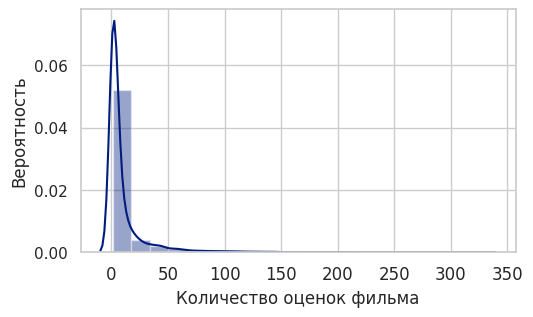

In [90]:
plt.figure(figsize=(5,3))
sns.distplot(df_n_ratings['total ratings'], bins=20)
plt.xlabel('Количество оценок фильма')
plt.ylabel('Вероятность')
plt.show()

##### Мы видим, что: 
* У большинства фильмов меньше 50 оценок.
* Количество фильмов с более чем 100 оценками очень низко.


##### Теперь посмотрим на обратный конец

In [36]:
df_n_ratings.sort_values('mean ratings', ascending=False).head(10)

,mean ratings,total ratings
title,,
Gena the Crocodile (1969),5.0,1
True Stories (1986),5.0,1
Cosmic Scrat-tastrophe (2015),5.0,1
Love and Pigeons (1985),5.0,1
Red Sorghum (Hong gao liang) (1987),5.0,1
"Thin Line Between Love and Hate, A (1996)",5.0,1
Lesson Faust (1994),5.0,2
Eva (2011),5.0,1
Who Killed Chea Vichea? (2010),5.0,1


In [92]:
print('Общее число фильмов с оценкой 5.0 : ', len(df_n_ratings.loc[df_n_ratings['mean ratings'] == 5]), '\n')
print('Общее число фильмов с одной оценкой, которая равна 5.0 : ', len(df_n_ratings.loc[(df_n_ratings['mean ratings'] == 5) 
                                                                           & (df_n_ratings['total ratings'] == 1)]))

Общее число фильмов с оценкой 5.0 :  296 

Общее число фильмов с одной оценкой, которая равна 5.0 :  289


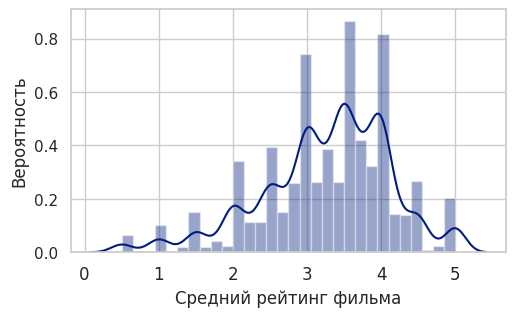

In [93]:
plt.figure(figsize=(5,3))
sns.distplot(df_n_ratings['mean ratings'], bins=30)
plt.xlabel('Средний рейтинг фильма')
plt.ylabel('Вероятность')
plt.show()

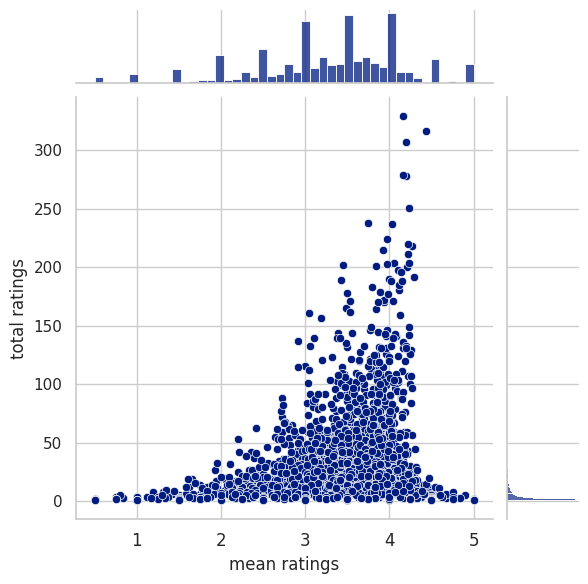

In [45]:
sns.jointplot(x = 'mean ratings', y = 'total ratings', data = df_n_ratings)

* Здесь каждая точка отображает отдельный фильм. По оси ординат отложено общее число пользователей, оценивших фильм; по оси абсцисс - его средний рейтинг.
* В районе 0-50 пользователей и 3-4 рейтинга наблюдается самая высокая плотность.

<a id="there_you_go_3"></a>
## 3) Коллаборативная фильтрация (Collaborative Filtering)

**Коллаборативная фильтрация** - метод автоматического прогнозирования (фильтрации) интересов пользователя путем сбора данных о предпочтениях большого количества других пользователей.

Основные подходы КФ разделяют на -->

1) **Корелляционные методы (Memory-Based CF)** - это подходы, которые обнаруживают сходство между пользователями или между продуктами, которое позволяет рекомендовать аналогичные продукты.

2) **Латентные модели (Model-Based CF)** - В этом подходе мы используем различные алгоритмы интеллектуального анализа данных и машинного обучения для прогнозирования оценок пользователей безрейтинговых элементов. Примеры включают сингулярное разложение (SVD), метод чередующихся наименьших квадратов (ALS) и т. Д.

#### Создадим кросс-табуляционную матрицу (User-Item Matrix)

In [46]:
util_mat = df_combined.pivot_table(index = 'userId', columns = 'title', values = 'rating')
util_mat.head(20)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


### 3.1) Корелляционные методы КФ (Memory-Based Collaborative Filtering)

Выделяют два подхода Memory-Based CF -->

1) **User-User Collaborative Filtering** - В этом случае мы вычисляем сходство всех пользователей с активным пользователем (пользователем, для которого хотим сделать прогноз). Затем сортируем и фильтруем топ N пользователей, чтобы сделать прогнозы для активного пользователя. Обычно это очень эффективно, но требует много времени и ресурсов. Например, если Петру и Ивану нравятся одни и те же фильмы, и выходит новый фильм, который нравится Ивану, то мы можем рекомендовать этот фильм Петру.

2) **Item-Item Collaborative Filtering** - Метод похож на User-User CF, только теперь мы вычисляем сходство между элементами, чтобы рекомендовать аналогичные продукты. Например, когда вы покупаете какой-либо продукт на Amazon, вы увидите строку «Пользователи, которые купили этот товар, также купили ...», так как Amazon широко использует Item-Item CF.


**Как оценить, насколько похожи пользователи/продукты?**

На самом деле есть немало способов, вот некоторые из них -->

1) **Коэффициент Жакара** - Это статистика, используемая для сравнения сходства и разнообразия множеств. Он определяется как размер пересечения, деленный на размер объединения множеств.

2) **Косинусовая метрика** - Отражает угол между векторами в пространстве рейтингов фильмов. Если угол равен 0 °, то это векторы имеющие одинаковую ориентацию, а если угол 180 °, то они сильно разнятся.

3) **Корелляция Пирсона** - На самом деле это подобие центрированного косинуса. Мы вычитаем средние оценки из оценок пользователей, чтобы среднее значение было сосредоточено на 0, а затем вычисляем косинусное сходство.

### 3.1.1) User based Collaborative Filtering

In [47]:
user_util_matrix = util_mat.copy()

# We will fill the row wise NaN's with the corresponding user's mean ratings, so that we can carry out Pearson correlation.
# Here we assume avg ratings for the movie that is not rated.
user_util_matrix = user_util_matrix.apply(lambda row: row.fillna(row.mean()), axis=1)
user_util_matrix.head(5)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,...,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.000000,4.366379
2,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,...,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276
3,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,...,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897
4,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,...,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556
5,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,...,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364


In [48]:
user_util_matrix.T.corr()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,1.264516e-03,5.525772e-04,0.048419,0.021847,-0.045497,-6.199672e-03,0.047013,1.950985e-02,-8.754088e-03,...,0.018127,-0.017172,-0.015221,-3.705875e-02,-2.912138e-02,0.012016,0.055261,0.075224,-2.571255e-02,0.010932
2,0.001265,1.000000e+00,-4.975816e-17,-0.017164,0.021796,-0.021051,-1.111357e-02,-0.048085,7.652805e-16,3.011629e-03,...,-0.050551,-0.031581,-0.001688,-1.265569e-15,-6.430371e-16,0.006226,-0.020504,-0.006001,-6.009100e-02,0.024999
3,0.000553,-4.975816e-17,1.000000e+00,-0.011260,-0.031539,0.004800,-2.587070e-16,-0.032471,-4.812885e-16,3.774064e-16,...,-0.004904,-0.016117,0.017749,-8.106536e-16,-1.430628e-03,-0.037289,-0.007789,-0.013001,-1.168878e-16,0.019550
4,0.048419,-1.716402e-02,-1.125978e-02,1.000000,-0.029620,0.013956,5.809139e-02,0.002065,-5.873603e-03,5.159032e-02,...,-0.037687,0.063122,0.027640,-1.378212e-02,4.003747e-02,0.020590,0.014628,-0.037569,-1.788358e-02,-0.000995
5,0.021847,2.179571e-02,-3.153892e-02,-0.029620,1.000000,0.009111,1.011715e-02,-0.012284,7.750436e-16,-3.316512e-02,...,0.015964,0.012427,0.027076,1.246135e-02,-3.627206e-02,0.026319,0.031896,-0.001751,9.382892e-02,-0.000278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.012016,6.225827e-03,-3.728895e-02,0.020590,0.026319,-0.009137,2.832591e-02,0.022277,3.163273e-02,-3.994577e-02,...,0.053683,0.016384,0.098011,6.107833e-02,1.967830e-02,1.000000,0.017927,0.056676,3.842210e-02,0.075464
607,0.055261,-2.050374e-02,-7.789105e-03,0.014628,0.031896,0.045501,3.098070e-02,0.048822,-1.216061e-02,-1.765576e-02,...,0.049059,0.038197,0.049317,2.355180e-03,-2.938114e-02,0.017927,1.000000,0.044514,1.904919e-02,0.021860
608,0.075224,-6.000828e-03,-1.300064e-02,-0.037569,-0.001751,0.021727,2.841409e-02,0.071759,3.278284e-02,-5.199963e-02,...,0.069198,0.051388,0.012801,6.318649e-03,-7.977761e-03,0.056676,0.044514,1.000000,5.071449e-02,0.054454


In [49]:
user_corr_mat = user_util_matrix.T.corr()
corr_user_1 = user_corr_mat.iloc[0]

Рассмотрим какого-то одного пользователя

In [50]:
corr_user_1.sort_values(ascending=False, inplace=True)

In [51]:
corr_user_1

userId
1      1.000000
301    0.124799
597    0.102631
414    0.101348
477    0.099217
         ...   
71    -0.082932
370   -0.086678
501   -0.090018
579   -0.105003
53          NaN
Name: 1, Length: 610, dtype: float64

In [52]:
# NaN values are generated in corr() as the std dev is zero, which is required in calculating Pearson Similarity.
corr_user_1.dropna(inplace = True)

In [53]:
# Neglect the 1st corr value as it is user1 itself
top50_corr_users = corr_user_1[1:51]

Ниже мы видим список всех фльмов, которые оценил пользователь 1

In [54]:
df_combined[df_combined['userId'] == 1]

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
215,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance
267,1,6,4.0,Heat (1995),Action|Crime|Thriller
369,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
572,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...,...,...
16056,1,3744,4.0,Shaft (2000),Action|Crime|Thriller
16075,1,3793,5.0,X-Men (2000),Action|Adventure|Sci-Fi
16208,1,3809,4.0,What About Bob? (1991),Comedy
16243,1,4006,4.0,Transformers: The Movie (1986),Adventure|Animation|Children|Sci-Fi


In [55]:
# user1 has not rated 32 movie
df_combined[ (df_combined['userId'] == 1) & (df_combined['movieId'] == 32) ] 

,userId,movieId,rating,title,genres


In [56]:
print('32nd Movie : ', movies['title'][ movies['movieId'] == 32 ].values)

32nd Movie :  ['Twelve Monkeys (a.k.a. 12 Monkeys) (1995)']


Итак, посчитаем, какие оценки дал бы фильму пользователь 1 с помощью метрики косинусов. И на основе этого рейтинга мы можем сравнить его с пороговым рейтингом. Если рейтинг выше, он будет виден активному пользователю в его рекомендованном списке.

In [57]:
df_n_ratings.loc[['Twelve Monkeys (a.k.a. 12 Monkeys) (1995)']]

,mean ratings,total ratings
title,,
Twelve Monkeys (a.k.a. 12 Monkeys) (1995),3.983051,177


In [58]:
top50_users = top50_corr_users.keys()

count = 0
users = list()
for user in top50_users:
    if df_combined[ (df_combined['userId'] == user) & (df_combined['movieId'] == 32) ]['rating'].sum()  :
        count +=1
        users.append(user)

print(count)

30


Среди Top-50 похожих пользователей есть 30, которые оценили фильм "The Twelve Monkeys".

Теперь посчитаем, какую оценки пользователь 1 дал бы этому фильму

 **Predicted rating** = $\sum_i (weight_i) * (rating_i)$  **/** $\sum_i (weight_i)$

Здесь, $weight_i$ - корреляция соответствующего пользователя с первым.



In [61]:
# Let's define a function to calculate what user1 will rate the movie
# We use Weighted average of k similar users

def predict_rating():
    sum_similarity = 0
    weighted_ratings = 0
    for user in users:
        weighted_ratings += top50_corr_users.loc[user] * df_combined[ (df_combined['userId'] == user) & 
                                                              (df_combined['movieId'] == 32) ]['rating'].sum()
        sum_similarity += top50_corr_users.loc[user]

    print(weighted_ratings / sum_similarity)
    
    
predict_rating()

4.1368953015974315


In [62]:
df_m[ df_m['movieId'] == 32]

,movieId,title,genres
31,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller


Что ж, есть неплохие шансы порекомендовать этот фильм первому пользователю, так как рейтинг неплохой.

Итак, вот как работает наивный пользовательский CF. Прогнозируемые рейтинги рассчитываются одинаково для каждого пользователя (очевидно, для фильмов, которые он не оценивал), и в зависимости от порогового рейтинга фильм либо отображается в его рекомендованном списке, либо отбрасывается.

### 3.1.2) Item Based Collaborative Filtering


* Этот алгоритм очень похож на предыдущий, но вместо того, чтобы искать похожих пользователей, мы пытаемся найти похожие фильмы.
* Когда у нас есть матрица похожих фильмов, мы можем легко рекомендовать похожие фильмы пользователям, которые оценили любой фильм из набора данных.

![Imgur](https://i.imgur.com/wKMnQiU.jpg)

In [63]:
# Let's find similar movies to jurassic Park
df_n_ratings.loc[['Jurassic Park (1993)']]

,mean ratings,total ratings
title,,
Jurassic Park (1993),3.75,238


In [64]:
item_util_matrix = util_mat.copy()
item_util_matrix.head(10)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


In [65]:
# We will fill the column wise NaN's with the corresponding movie's mean ratings, so that we can carry out Pearson correlation.
# Here we assume avg ratings for the user that has not a rated movie.

item_util_matrix = item_util_matrix.apply(lambda col : col.fillna(col.mean()), axis=0)
item_util_matrix.head(5)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,4.0,3.5,5.0,4.0,1.5,3.176471,3.0,3.666667,3.285714,...,1.5,4.0625,3.666667,3.0,3.0,3.863636,2.770833,2.0,4.000000,1.0
2,4.0,4.0,3.5,5.0,4.0,1.5,3.176471,3.0,3.666667,3.285714,...,1.5,4.0625,3.666667,3.0,3.0,3.863636,2.770833,2.0,3.134615,1.0
3,4.0,4.0,3.5,5.0,4.0,1.5,3.176471,3.0,3.666667,3.285714,...,1.5,4.0625,3.666667,3.0,3.0,3.863636,2.770833,2.0,3.134615,1.0
4,4.0,4.0,3.5,5.0,4.0,1.5,3.176471,3.0,3.666667,3.285714,...,1.5,4.0625,3.666667,3.0,3.0,3.863636,2.770833,2.0,3.134615,1.0
5,4.0,4.0,3.5,5.0,4.0,1.5,3.176471,3.0,3.666667,3.285714,...,1.5,4.0625,3.666667,3.0,3.0,3.863636,2.770833,2.0,3.134615,1.0


In [66]:
item_util_matrix.isna().sum().sum()

0

This signifies that every Movie is rated by atleast 1 user.

In [67]:
item_util_matrix.corr()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Hellboy': The Seeds of Creation (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Round Midnight (1986),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Salem's Lot (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Til There Was You (1997),NaN,NaN,NaN,NaN,1.000000e+00,NaN,-2.470228e-17,NaN,-6.783236e-16,-4.090781e-16,...,NaN,1.491400e-15,-2.970631e-18,NaN,NaN,-1.174172e-16,-4.643126e-16,-1.457468e-15,2.901144e-15,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eXistenZ (1999),NaN,NaN,NaN,NaN,-1.174172e-16,NaN,6.069910e-02,NaN,-7.527708e-02,2.947366e-02,...,NaN,-1.447002e-15,-3.196632e-16,NaN,NaN,1.000000e+00,3.784587e-02,1.243849e-15,-3.410933e-02,NaN
xXx (2002),NaN,NaN,NaN,NaN,-4.643126e-16,NaN,-3.527098e-03,NaN,1.558884e-01,2.511177e-01,...,NaN,-2.067568e-01,-4.854206e-03,NaN,NaN,3.784587e-02,1.000000e+00,2.449296e-01,1.854832e-02,NaN
xXx: State of the Union (2005),NaN,NaN,NaN,NaN,-1.457468e-15,NaN,6.027298e-16,NaN,1.107823e-01,-1.311693e-15,...,NaN,-2.014024e-01,7.715167e-02,NaN,NaN,1.243849e-15,2.449296e-01,1.000000e+00,1.034849e-15,NaN


* Существует много значений NaN, и это потому, что, когда мы вычисляем корреляцию Пирсона, если вектор рейтинга имеет все одинаковые значения, например -> [3.0, 3.0, 3.0, 3.0, ....], тогда **стандартное отклонение** равно нулю, и деление на ноль не определено, поэтому его корреляция с любым другим вектором рейтинга равна NaN.

* Поскольку существует много фильмов, которые оцениваются только одним пользователем, среднее значение столбца заполняется рейтингом этого пользователя, и поэтому корреляция Пирсона дает значения NaN с любым другим столбцом.

In [68]:
item_corr_matrix = item_util_matrix.corr()

In [69]:
jurassic_park_corr = item_corr_matrix['Jurassic Park (1993)']
jurassic_park_corr = jurassic_park_corr.sort_values(ascending=False)
jurassic_park_corr.dropna(inplace=True)

In [70]:
movies_similar_to_jurassic_park = pd.DataFrame(data=jurassic_park_corr.values, columns=['Correlation'], 
                                               index = jurassic_park_corr.index)
movies_similar_to_jurassic_park = movies_similar_to_jurassic_park.join(df_n_ratings['total ratings'])
movies_similar_to_jurassic_park.head(10)

,Correlation,total ratings
title,,
Jurassic Park (1993),1.000000,238
"Fugitive, The (1993)",0.324717,190
Lethal Weapon (1987),0.318646,75
Independence Day (a.k.a. ID4) (1996),0.263629,202
Mission: Impossible (1996),0.258080,162
Ghostbusters (a.k.a. Ghost Busters) (1984),0.256527,120
Mulan (1998),0.255672,45
Rise of the Planet of the Apes (2011),0.248134,27
"Bug's Life, A (1998)",0.240964,92


In [71]:
movies_similar_to_jurassic_park = movies_similar_to_jurassic_park[1:]
movies_similar_to_jurassic_park[ movies_similar_to_jurassic_park['total ratings'] > 100 ].sort_values(ascending=False,
                                                                                          by=['Correlation']).head(10)

,Correlation,total ratings
title,,
"Fugitive, The (1993)",0.324717,190
Independence Day (a.k.a. ID4) (1996),0.263629,202
Mission: Impossible (1996),0.258080,162
Ghostbusters (a.k.a. Ghost Busters) (1984),0.256527,120
Indiana Jones and the Temple of Doom (1984),0.239826,108
Die Hard (1988),0.239294,145
Aladdin (1992),0.227711,183
Braveheart (1995),0.222085,237
Speed (1994),0.220720,171


### 3.2) Латентные модели

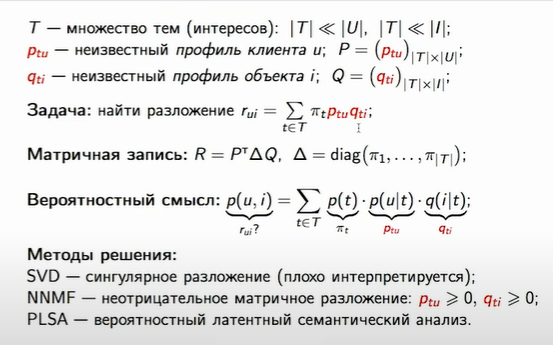

Здесь мы будем использовать методы уменьшения размерности для повышения надежности и точности CF. По сути, мы сжимаем матрицу пользовательских элементов в матрицу низкой размерности. Мы ,будем использовать такие методы, как SVD и NMF, который представляет собой метод факторизации низкого ранга

Латентные методы основаны на факторизации матрицы и лучше справляются с разреженностью.

In [78]:
from surprise import Reader, Dataset, KNNBasic, SVD, NMF
from surprise.model_selection import GridSearchCV, cross_validate

In [79]:
reader = Reader(rating_scale=(0.5, 5.0))

data = Dataset.load_from_df( ratings[['userId', 'movieId', 'rating']], reader = reader )

### 3.2.1) K-Nearest Neighbours (KNN)

In [51]:
# Split data into k-folds
# data.split(n_folds=5)

In [85]:
# Compute Mean Squared Distance Similarity
sim_options = {'name' : 'msd'}

algo_1 = KNNBasic(k=20, sim_options=sim_options )
cross_validate(algo=algo_1, data=data, measures=['RMSE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9438  0.9486  0.9399  0.9352  0.9420  0.9419  0.0044  
Fit time          0.24    0.26    0.25    0.18    0.17    0.22    0.04    
Test time         4.35    4.10    3.61    2.53    2.29    3.38    0.83    


{'test_rmse': array([0.94376506, 0.94862551, 0.93993214, 0.93517601, 0.94198982]),
 'fit_time': (0.2357640266418457,
  0.26285791397094727,
  0.24998950958251953,
  0.18407845497131348,
  0.1709287166595459),
 'test_time': (4.3503193855285645,
  4.10172438621521,
  3.607429265975952,
  2.534290313720703,
  2.2899789810180664)}

**Tuning KNN using GridSearchCV**

In [86]:
n_neighbours_1 = [10, 20, 30]
param_grid_1 = {'n_neighbours' : n_neighbours_1}

gs_1 = GridSearchCV(KNNBasic, measures=['RMSE'], param_grid=param_grid_1)
gs_1.fit(data)

print('\n\n###############')
# Best RMSE score
print('Best Score :', gs_1.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print('Best Parameters :', gs_1.best_params['rmse'])
print('###############')

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

### 3.2.2) Singular Value Decomposition (SVD)

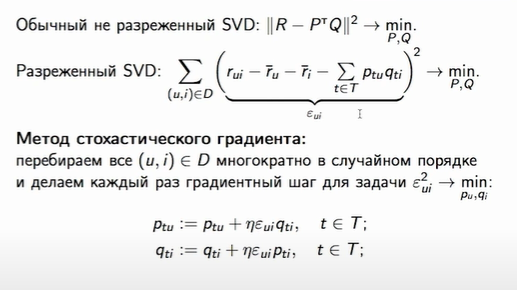

In [82]:
algo_2 = SVD()
cross_validate(algo=algo_2, data=data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8724  0.8703  0.8803  0.8749  0.8677  0.8731  0.0043  
Fit time          8.59    12.89   12.46   13.10   12.97   12.00   1.72    
Test time         0.40    0.26    0.60    0.28    0.53    0.42    0.13    


{'test_rmse': array([0.87236045, 0.8702641 , 0.88025359, 0.87493518, 0.86765905]),
 'fit_time': (8.585767030715942,
  12.88587474822998,
  12.463637113571167,
  13.09782361984253,
  12.970486879348755),
 'test_time': (0.39938831329345703,
  0.2642073631286621,
  0.5954046249389648,
  0.28287291526794434,
  0.5341269969940186)}

**Fine Tuning SVD using GridSearchCV**

[Click here to view the parameters](https://surprise.readthedocs.io/en/stable/matrix_factorization.html)

In [83]:
param_grid_2= {'n_factors' : [50, 75], 'lr_all' : [0.5, 0.05], 'reg_all' : [0.06, 0.04]}

gs_2 = GridSearchCV(algo_class=SVD, measures=['RMSE'], param_grid=param_grid_2)
gs_2.fit(data)

print('\n###############')
# Best RMSE score
print('Best Score :', gs_2.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print('Best Parameters :', gs_2.best_params['rmse'])
print('###############')


###############
Best Score : 0.8641300681601571
Best Parameters : {'n_factors': 75, 'lr_all': 0.05, 'reg_all': 0.06}
###############


### 3.2.3) Non-Negative Matrix Factorization (NMF)

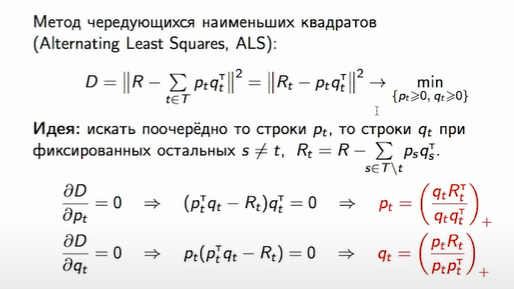

In [84]:
algo = NMF()
cross_validate(data=data, algo=algo, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9174  0.9264  0.9314  0.9179  0.9195  0.9225  0.0055  
Fit time          9.88    12.43   13.09   14.40   12.27   12.41   1.47    
Test time         0.25    0.48    0.52    0.39    0.47    0.42    0.10    


{'test_rmse': array([0.91737638, 0.92640544, 0.93141395, 0.91794387, 0.91951848]),
 'fit_time': (9.884662866592407,
  12.425657510757446,
  13.091798543930054,
  14.397157907485962,
  12.272886991500854),
 'test_time': (0.24745440483093262,
  0.480975866317749,
  0.5191035270690918,
  0.3949918746948242,
  0.46694493293762207)}

In [89]:
algo.pu

array([[0.43041162, 0.77650263, 0.43125741, ..., 0.69639733, 0.32761636,
        0.63767624],
       [0.39471915, 0.53741461, 0.10194687, ..., 0.41161951, 0.43422064,
        0.80568299],
       [0.12014189, 0.9378585 , 0.72312873, ..., 0.01205789, 0.85325022,
        0.33273152],
       ...,
       [0.65158698, 0.71146217, 0.09188336, ..., 0.4399812 , 1.48131279,
        0.11107753],
       [0.32109333, 0.3760913 , 0.59309431, ..., 1.16409094, 0.24805946,
        0.50041746],
       [0.06579559, 0.31619859, 0.33610012, ..., 0.38491084, 0.52127287,
        1.0231917 ]])